## Setup

In [1]:
from pprint import pprint
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Setup spark session
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.102:7077")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","100s")\
        .config("spark.sql.broadcastTimeout","600s")\
        .config("spark.executor.cores",2)\
        .config("spark.executor.memory",'4g')\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .appName("Analyse-1")\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

22/03/16 22:03:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/16 22:03:58 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


## Import data

In [2]:
#Import data
data_frame = spark_session.read\
    .option("header", "true")\
    .csv('hdfs://192.168.2.102:9000/data_q4_2021/*.csv')\
    .cache()
data_frame.rdd.getNumPartitions()

92

In [3]:
#Remove unnecessary columns
column_filter = ["date","serial_number","model","failure","smart_9_raw"]
filtered_df = data_frame.select(*column_filter)

## Number of drives

In [4]:
num_drives_by_date = filtered_df.groupBy("date").count().orderBy("date").collect()

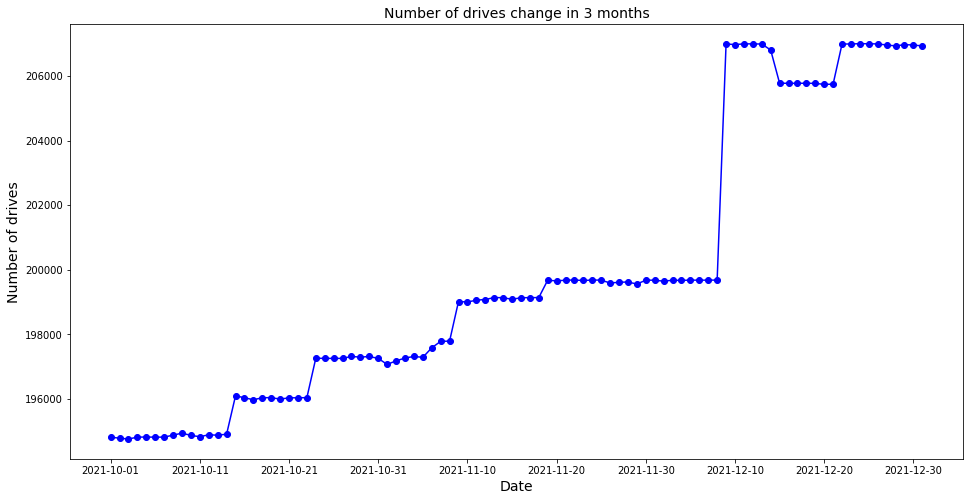

In [5]:
# Plot result
plt.figure(figsize=(16,8))
plt.plot([a[0] for a in num_drives_by_date], [a[1] for a in num_drives_by_date], color='blue', marker='o')
plt.title('Number of drives change in 3 months', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of drives', fontsize=14)
plt.xticks(range(0,len(num_drives_by_date),10))
plt.show()

## Failed drives

In [6]:
num_failures_by_date = filtered_df.filter(filtered_df["failure"] == 1).groupBy("date").count().collect()

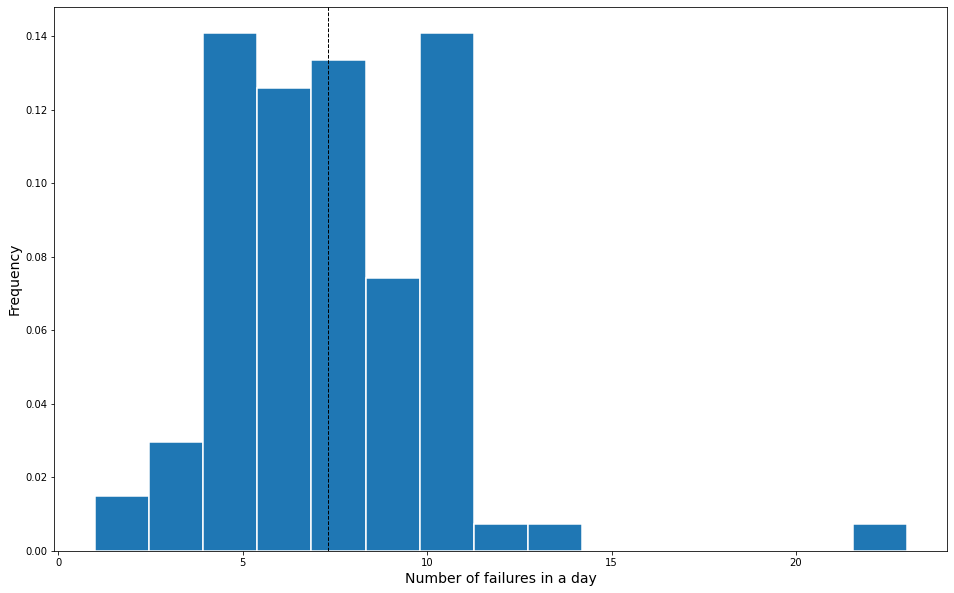

In [7]:
#Number of failures list
x = [a[1] for a in num_failures_by_date]

plt.figure(figsize=(16,10))
plt.hist(x, density=True, bins=15, edgecolor='white', linewidth=1.5)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Number of failures in a day',fontsize=14);
plt.axvline(np.mean(np.array(x)), color='k', linestyle='dashed', linewidth=1)
plt.show()

## Drive models stats

In [8]:
#failures_by_model: ('Drive model','number of failed drives')
failures_by_model = filtered_df.filter(filtered_df["failure"] == 1).groupBy("model").count().withColumnRenamed("count","failure_counts")

In [12]:
#model_count: ('Drive model', 'total number of unique drives spinning')
model_count = filtered_df.select("model","serial_number").distinct().groupBy("model").count()

In [13]:
#Join table of failures_by_model and model_count
accu_count = model_count.join(failures_by_model,"model").collect()

In [14]:
#Accumulated result presentation
print(tabulate(accu_count, headers=["Drive model","Total drives","Failure count"], tablefmt="grid", showindex="always"))

+----+----------------------------------------+----------------+-----------------+
|    | Drive model                            |   Total drives |   Failure count |
+====+========================================+================+=================+
|  0 | ST4000DM000                            |          18712 |             102 |
+----+----------------------------------------+----------------+-----------------+
|  1 | ST12000NM0007                          |           1515 |              17 |
+----+----------------------------------------+----------------+-----------------+
|  2 | TOSHIBA MQ01ABF050M                    |            314 |              17 |
+----+----------------------------------------+----------------+-----------------+
|  3 | ST8000NM0055                           |          14424 |              62 |
+----+----------------------------------------+----------------+-----------------+
|  4 | TOSHIBA MG07ACA14TA                    |          38300 |              88 |
+---

## Failure and time on power

In [16]:
time_on_before_failed = filtered_df.filter(filtered_df["failure"] == 1).select("smart_9_raw").collect()

In [22]:
time_on_before_failed[0][0]

'42550'

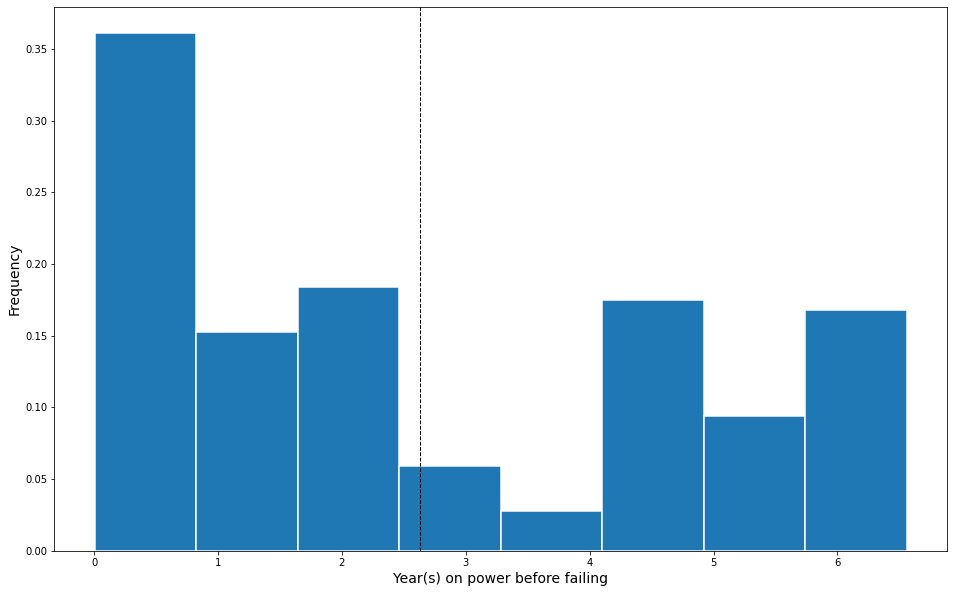

In [41]:
# Remove None value (where S.M.A.R.T attribute is not recorded/available) and convert unit to year
processed_time_on_before_failed = [float(a[0])/(365*24) for a in time_on_before_failed if a[0]] 

plt.figure(figsize=(16,10))
plt.hist(processed_time_on_before_failed, density=True, bins=8, edgecolor='white', linewidth=1.5)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Year(s) on power before failing',fontsize=14);
plt.axvline(np.mean(np.array(processed_time_on_before_failed)), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [6]:
spark_session.stop()